<a href="https://colab.research.google.com/github/caresppen/KSCHOOL/blob/master/GCP_BigQuery_Clinical_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated!')

Authenticated!


In [3]:
%%bigquery --project crucial-quarter-310117 df

SELECT
    class.code as encounter_class,
    period.start as start_timestamp,
    period.end as end_timestamp, 
    TIMESTAMP_DIFF(TIMESTAMP(period.end), TIMESTAMP(period.start), HOUR) 
        as length_of_stay_in_hours
FROM 
    `hcls-testing-data.fhir_20k_patients_analytics.Encounter`
WHERE
    period.end >= period.start
ORDER BY
    4 DESC
LIMIT 10

In [4]:
df.head()

,encounter_class,start_timestamp,end_timestamp,length_of_stay_in_hours
0,EMER,1916-10-31T13:41:30+00:00,2010-06-22T13:41:30+00:00,820848
1,EMER,1913-12-12T12:46:28+00:00,1979-05-01T12:46:28+00:00,573144
2,EMER,1957-05-28T21:08:46+00:00,2012-02-07T21:08:46+00:00,479472
3,EMER,1966-01-07T20:54:48+00:00,2018-11-30T20:54:48+00:00,463680
4,EMER,1931-05-12T13:33:40+00:00,1981-05-22T13:33:40+00:00,438552


In [5]:
%%bigquery --project crucial-quarter-310117 df2

SELECT
  cc.code loinc_code,
  cc.display loinc_name,
  approx_quantiles(round(o.value.quantity.value,1),4) as quantiles,
  count(*) as num_obs
FROM
  `hcls-testing-data.fhir_20k_patients_analytics.Observation` o, o.code.coding cc
WHERE
  cc.system like '%loinc%' and lower(cc.display) like '%cholesterol%'
GROUP BY 1,2
ORDER BY 4 desc

In [6]:
df2.head()

,loinc_code,loinc_name,quantiles,num_obs
0,2093-3,Total Cholesterol,"[150.0, 172.7, 188.0, 206.1, 304.8]",100304
1,18262-6,Low Density Lipoprotein Cholesterol,"[51.0, 83.3, 99.0, 128.3, 199.9]",100304
2,2085-9,High Density Lipoprotein Cholesterol,"[0.1, 49.2, 63.2, 71.6, 80.0]",100304


In [7]:
%%bigquery --project crucial-quarter-310117 df3

SELECT
  encounter_class,
  APPROX_QUANTILES(num_encounters, 4) num_encounters_quantiles
FROM (
  SELECT
    class.code encounter_class,
    subject.reference patient_id,
    COUNT(DISTINCT id) AS num_encounters
  FROM
    `hcls-testing-data.fhir_20k_patients_analytics.Encounter`
  GROUP BY
    1,2
  )
GROUP BY 1
ORDER BY 1

In [8]:
df3.head()

,encounter_class,num_encounters_quantiles
0,AMB,"[736512, 736512, 736512, 736512, 736512]"
1,EMER,"[40824, 40824, 40824, 40824, 40824]"
2,IMP,"[26540, 26540, 26540, 26540, 26540]"


In [9]:
%%bigquery --project crucial-quarter-310117 df4

SELECT
  class.code encounter_class,
  ROUND(AVG(TIMESTAMP_DIFF(TIMESTAMP(period.end), TIMESTAMP(period.start), MINUTE)),1) as avg_minutes
FROM
  `hcls-testing-data.fhir_20k_patients_analytics.Encounter`
WHERE
  period.end >= period.start
GROUP BY
  1
ORDER BY
  2 DESC

In [10]:
df4.head()

,encounter_class,avg_minutes
0,EMER,19754.7
1,IMP,2991.9
2,AMB,1529.0


In [12]:
%%bigquery --project crucial-quarter-310117 df5

SELECT
  id AS encounter_id,
  period.start AS encounter_start,
  period.end AS encounter_end,
  status AS encounter_status,
  class.code AS encounter_type,
  subject.patientId as patient_id,
  participant[safe_OFFSET(0)].individual.practitionerId as parctitioner_id,
  serviceProvider.organizationId as encounter_location_id,
  type[safe_OFFSET(0)].text AS encounter_reason
FROM
  `hcls-testing-data.fhir_20k_patients_analytics.Encounter` AS Encounter
WHERE
  subject.patientId = "900820eb-4166-4981-ae2d-b183a064ac18"
ORDER BY
  encounter_end

In [13]:
df5.head()

,encounter_id,encounter_start,encounter_end,encounter_status,encounter_type,patient_id,parctitioner_id,encounter_location_id,encounter_reason
0,f3ac19de-76ff-442d-90dc-9a1cf0cb36d2,1909-04-04T21:58:24+00:00,1909-04-05T01:41:24+00:00,finished,EMER,900820eb-4166-4981-ae2d-b183a064ac18,18ab1a0d-54c7-438a-b904-fe3d24f5dba2,23834663-ed53-3da9-b330-d6e1ecb8428e,Emergency Room Admission
1,bcff40c0-ee4c-492c-bc19-8e24f9c2e3c9,1912-04-10T21:58:24+00:00,1912-04-24T21:58:24+00:00,finished,AMB,900820eb-4166-4981-ae2d-b183a064ac18,18ab1a0d-54c7-438a-b904-fe3d24f5dba2,23834663-ed53-3da9-b330-d6e1ecb8428e,Encounter for symptom
2,c172ef71-2f47-48ff-a3bc-d7973f89e1a1,1912-05-03T21:58:24+00:00,1912-05-03T22:13:24+00:00,finished,AMB,900820eb-4166-4981-ae2d-b183a064ac18,18ab1a0d-54c7-438a-b904-fe3d24f5dba2,23834663-ed53-3da9-b330-d6e1ecb8428e,Encounter for problem
3,c5eab90e-b978-45f7-95b3-08adcbc628ba,1941-04-06T21:58:24+00:00,1941-04-06T22:13:24+00:00,finished,AMB,900820eb-4166-4981-ae2d-b183a064ac18,18ab1a0d-54c7-438a-b904-fe3d24f5dba2,23834663-ed53-3da9-b330-d6e1ecb8428e,Encounter for problem
4,3dd20ad4-4db0-44a6-9107-1c73caf4ffba,1941-06-15T21:58:24+00:00,1941-06-15T22:58:24+00:00,finished,EMER,900820eb-4166-4981-ae2d-b183a064ac18,977d08c9-7b88-49d9-9484-964c8da27513,ecc51621-0af3-3b35-ac3e-8b1e34022e92,Emergency room admission (procedure)


In [14]:
%%bigquery --project crucial-quarter-310117 df6

SELECT
  id AS org_id,
  type[safe_offset(0)].text AS org_type,
  name AS org_name,
  address[safe_offset(0)].line AS org_addr,
  address[safe_offset(0)].city AS org_addr_city,
  address[safe_offset(0)].state AS org_addr_state,
  address[safe_offset(0)].postalCode AS org_addr_postalCode,
  address[safe_offset(0)].country AS org_addr_country
FROM 
  `hcls-testing-data.fhir_20k_patients_analytics.Organization` AS Organization
WHERE 
  id = "b81688f5-bd0e-3c99-963f-860d3e90ab5d"

In [15]:
df6.head()

,org_id,org_type,org_name,org_addr,org_addr_city,org_addr_state,org_addr_postalCode,org_addr_country
0,b81688f5-bd0e-3c99-963f-860d3e90ab5d,Healthcare Provider,URGENT CARE MEDICAL CLINIC,[581 BOYLSTON STREET],BOSTON,MA,2116,US


In [16]:
%%bigquery --project crucial-quarter-310117 df7

SELECT
  id AS patient_id,
  name[safe_offset(0)].given AS given_name,
  name[safe_offset(0)].family AS family,
  telecom[safe_offset(0)].value AS phone,
  birthDate AS birth_date,
  deceased.dateTime AS deceased_datetime,
  Gender AS fhir_gender_code,
  Address[safe_offset(0)].line AS address1_line_1,
  Address[safe_offset(0)].city AS address1_city,
  Address[safe_offset(0)].state AS address1_state,
  Address[safe_offset(0)].postalCode AS address1_postalCode,
  Address[safe_offset(0)].country AS address1_country
FROM 
  `hcls-testing-data.fhir_20k_patients_analytics.Patient` AS Patient 
LIMIT 10

In [17]:
df7.head()

,patient_id,given_name,family,phone,birth_date,deceased_datetime,fhir_gender_code,address1_line_1,address1_city,address1_state,address1_postalCode,address1_country
0,66d26781-f80d-4f98-9f46-e64f4dbe8704,[Junior695],Kuhn96,555-117-4940,1958-10-09,None,male,[675 Price Corner Unit 69],Clarksburg,Massachusetts,None,US
1,9cf7fc60-3078-4d3f-9978-5a6234a57ed6,[Selene142],Koelpin146,555-821-3805,1974-06-22,None,female,[194 Boehm Way],Clarksburg,Massachusetts,None,US
2,002d54b4-c232-4577-b397-52d45d978145,[Sharen57],Bogisich202,555-838-9098,1965-11-02,1966-05-17T14:51:30+00:00,female,[830 Sporer Alley],Lowell,Massachusetts,01850,US
3,13b82c64-a770-49d0-b18a-4183cde1ef4e,[Ariel183],Lindgren255,555-769-3394,2002-04-02,None,male,[683 Padberg Harbor],Lowell,Massachusetts,01850,US
4,1413465f-eade-4a07-bdcc-be5959077392,[Melany872],Eichmann909,555-113-2935,2002-12-30,None,female,[162 Dickens Quay],Lowell,Massachusetts,01850,US


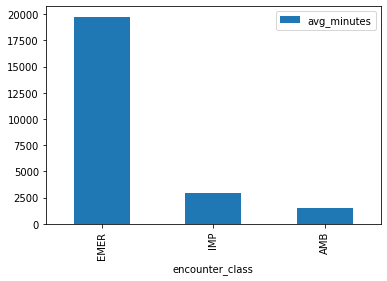

In [18]:
df4.plot(kind='bar', x='encounter_class', y='avg_minutes');